# EEEN30131 Power System Analysis: Week 05 - Interconnected Systems

***&copy; 2024 Martínez Ceseña — University of Manchester, UK***

This notebook provides several examples covering primary and secondary frequency regulation, including general `python` code which can be used to solve the examples and create new ones.

The use of the notebooks is optional and will not be marked. That said, you are strongly encouraged to play with the tools and examples, as such activities will better prepare you for the exams.

## List of contents

- [DC Power flow approximation](#DC-Power-flow-approximation)
- [Interconnected systems](#Interconnected-systems)
- [Interconnected system dinamycs](#Interconnected-system-dinamycs)
  - [Primary response](#Primary-response)
  - [Secondary response](#Secondary-response)

## Before we begin

Before we begin: 
- Make sure to review the asynchronous materials provided in blackboard for EEEN30131 Week 4 - Frequency regulation 

This notebook builds on the materials that were presented during the last week. Therefore, make sure to review the asynchronous materials provided in blackboard for EEEN30131:
  - Week 4 - Frequency regulation
  - Week 5 - Interconnected systems

Also, the interconnected models are based on a simplified approach to model power flows. Therefore, it is also recommended to review our previous lectures on power flow analysis:
  - Week 1 - Nodal analysis 
  - Week 2 - Power Flow Formulation 
  - Week 3 - Newton Raphson

- If you have any questions, please post them in the discussion boards or, if that is not possible, send an email to alex.martinezcesena@manchester.ac.uk

If this data notebook is being used in Jupyter lite, the folders where the python code that supports this notebook are stored, have to be enabled.

In [ ]:
from pathlib import Path
if Path.cwd().drive == '':
    a_dir = Path("dir")
    a_dir.mkdir(exist_ok=True)

Also, the following general python libraries are needed:

In [ ]:
import numpy
import control
import matplotlib.pyplot as plt

The notebook borrows several tools developed in previous weeks, so we need to import them here:

In [1]:
from Code.Wk1_EEEN30131 import get_Ybus
from Code.Wk2_EEEN30131 import get_Bus_Type, develop_PF_Equations
from Code.Wk3_EEEN30131 import Newtons_Method, Visualize_Elec
from Code.Wk4_EEEN30131 import get_Primary_Response, get_pu, get_Δw, get_step

[Back to top](#EEEN30131-Power-System-Analysis:-Week-05---Interconnected-Systems)

## DC Power flow approximation

There are different approaches to solve and simplify the power flow problem. A well established simplification is the DC model:

$$
P_{i,j} = \frac{\theta_i - \theta_j}{X_{i,j}}
$$

For this approximation to be reasonable, the resistances should be negligible and the voltage magnitudes should be close to one pu. To illustrate this, the DC model and its solution (using a direct method) are coded in the methods below.

In [3]:
def run_DCPF(Connectivity, Load, Generator):
    # Finding slack bus
    for gen in Generator:
        if 'V' in gen.keys() and '𝜃' in gen.keys():
            Slack = gen['Bus'] - 1
            break
    if Slack is None:
        print('The slack bus is missing')
        return False, None, None

    # Getting number of buses
    No_Buses = 0
    for line in Connectivity:
        No_Buses = max([No_Buses, line[0], line[1]])

    # Building Y bus
    M = numpy.zeros((No_Buses-1, No_Buses-1))
    for line in Connectivity:
        y = 1/line[2].imag
        i = line[0] - 1
        j = line[1] - 1

        if i != Slack:
            if i > Slack:
                i -= 1
            M[i, i] += y
            if j != Slack:
                if j > Slack:
                    j -= 1
                M[j, i] -= y
                M[i, j] -= y
                M[j, j] += y

        elif j != Slack:
            if j > Slack:
                j -= 1
            M[j, j] += y

    ΔP = numpy.zeros(No_Buses-1)
    for gen in Generator:
        if 'P' in gen.keys():
            i = gen['Bus']-1
            if i != Slack:
                if i > Slack:
                    i -= 1
                ΔP[i] += gen['P']

    for ld in Load:
        i = ld[0]-1
        if i != Slack:
            if i > Slack:
                i -= 1
            ΔP[i] -= ld[1].real

    # Solve DC flows
    Δ𝜃 = numpy.linalg.inv(M).dot(ΔP)
    𝜃 = numpy.zeros(No_Buses)
    P = numpy.zeros(No_Buses)
    P[Slack] = sum(ΔP)
    i = 0
    for x in range(No_Buses):
        if x != Slack:
            𝜃[x] = Δ𝜃[i]
            P[x] = ΔP[i]
            i += 1

    return True, 𝜃, P


def Visualize_DC(Connectivity, 𝜃, P, Succes):
    if not Succes:
        return

    Base = 100
    No_Buses = len(P)
    print('NET POWER INJECTIONS:')
    for xb in range(No_Buses):
        print('%2.0f) %8.4f MW' % (xb+1, P[xb]*Base))

    print('POWER FLOWS:')
    for line in Connectivity:
        i = line[0]
        j = line[1]
        f = (𝜃[i-1]-𝜃[j-1])/line[2].imag*Base
        print('%2.0f-%2.0f) %8.4f ' % (i, j, f))
    print()

[Back to top](#EEEN30131-Power-System-Analysis:-Week-05---Interconnected-Systems)

Let us use an example to compare the AC and DC representations of the power flow problem.

<img src="Figures/Week02_3Bus_Empty.png" alt="Fig01" class="bg-primary" width="500px">

In [4]:
Connectivity = [
    [1, 2, complex(0, 0.01)],
    [1, 3, complex(0, 0.02)],
    [2, 3, complex(0, 0.03)]
]
Load = [
    [2, complex(1.5, 0.37)]
]
Generator = [
    {'Bus':1, 'V':1, '𝜃':0 },
    {'Bus':3, 'P':1, 'Q':0.25}
]

Succes, 𝜃, P = run_DCPF(Connectivity, Load, Generator)
Visualize_DC(Connectivity, 𝜃, P, Succes)

# From Week 01
Ybus = get_Ybus(Connectivity, True, False)

# From Week 02
P_Data, Q_Data = develop_PF_Equations(Load, Generator, Ybus, True, False)
Bus_Data, Bus_Type = get_Bus_Type(Ybus, Load, Generator)

# From Week 03
V_All, 𝜃_All, Threshold, Succes = Newtons_Method(P_Data, Q_Data, Bus_Data, Bus_Type, Generator, 0)
Visualize_Elec(Connectivity, V_All, 𝜃_All, Succes)

NET POWER INJECTIONS:
 1) -50.0000 MW
 2) -150.0000 MW
 3) 100.0000 MW
POWER FLOWS:
 1- 2)  91.6667 
 1- 3) -41.6667 
 2- 3) -58.3333 

VOLTAGES  [pu] [deg]:
 1)   1.0000 +j   0.0000 (  1.0000 ∠   0.0000)
 2)   0.9976 +j  -0.0092 (  0.9976 ∠  -0.5265)
 3)   1.0019 +j   0.0083 (  1.0020 ∠   0.4766)
NET POWER INJECTIONS [MVA]:
 1)  50.0000 +j  14.3476
 2) -150.0000 +j -37.0000
 3) 100.0000 +j  25.0000
CURRENTS [pu] [deg]:
 1- 2)   0.9167 +j  -0.2402 (  0.9476 ∠ -14.6807)
 1- 3)  -0.4167 +j   0.0967 (  0.4278 ∠ 166.9370)
 2- 3)  -0.5834 +j   0.1445 (  0.6010 ∠ 166.0868)
POWER FLOWS [MVA]:
      From:                To:                   Loss:
 1- 2)  91.6705 +j  24.0163 -91.6705 +j -23.1183 (  0.0000 +j   0.8980)
 1- 3) -41.6705 +j  -9.6687  41.6705 +j  10.0347 (  0.0000 +j   0.3660)
 2- 3) -58.3295 +j -13.8817  58.3295 +j  14.9653 (  0.0000 +j   1.0836)


[Back to top](#EEEN30131-Power-System-Analysis:-Week-05---Interconnected-Systems)

## Interconnected systems

The tools developed in the last session for area frequency response can also be used to model interconnected systems.

![Week05_Interconnecteds.png](Figures/Week05_Interconnected.png)

>Note that if a Base is not defined for the loads, the model will estimate pu values assuming the base of the loads and the system are the same.

In [5]:
Dist = {
    'Area':1,
    'Magnitude': -100,  # Positive: Generation is higher than load
    'Flow': 100  # From area 1 to 2 by default
}
Gen = [
    {'Area':1, 'Capacity': 500, 'R':0.01, 'Units': 'pu', 'Output': 0},
    {'Area':2, 'Capacity': 500, 'R':0.02, 'Units': 'pu', 'Output': 0}
]
Load = [
    {'D':0.8, 'Units': 'pu', 'Base':500},
    {'D':1.0, 'Units': 'pu', 'Base':500}
]
Base = 500
F = 50

get_Primary_Response(Dist, Gen, Load, Base, F)

A disturbance occurred in Area 1
As a result generation is suddenlly lower than demand by 100.0000 MW

Disturbance: -100.0000 MW (-0.2000 pu)
G1) Area1, Capacity:     500.00 MW, R:    0.0100 pu, Output:      0.00 MW
G2) Area2, Capacity:     500.00 MW, R:    0.0200 pu, Output:      0.00 MW
L1) Area1, D: 0.8000 pu
L2) Area2, D: 1.0000 pu
*Assuming a 500 MVA base

The frequency changed by -0.0013 pu (-0.0659 Hz), so the new freqency is 49.9341 Hz
           ∆Pm and D∆ω     Operation
          (pu)       (MW)       (MW)
G1)     0.1318    65.8762    65.8762 (    0.0000+   65.8762+    0.0000)
G2)     0.0659    32.9381    32.9381 (    0.0000+   32.9381+    0.0000)
L1)    -0.0011    -0.5270
L2)    -0.0013    -0.6588
All:             100.0000


Now that we have the response of each area, additional methods are needed to calculate and display the flow across the line.

In [6]:
def get_TieLine(Δw, Disturbance, Generators, Damping, Base):
    if Disturbance['Area'] == 1:
        area = 2
        ΔPtie_pu = Damping[1]['D']
    else:
        area = 1
        ΔPtie_pu = Damping[0]['D']

    for gen in Generators:
        if gen['Area'] == area:
            ΔPtie_pu += 1/gen['R']

    ΔPtie_pu *= Δw
    ΔPtie = ΔPtie_pu*Base

    if Disturbance['Magnitude'] < 0:  # Higher load than generation
        a1 = area
        a2 = Disturbance['Area']
    else:
        a1 = Disturbance['Area']
        a2 = area

    Ptie = Disturbance['Flow']
    if (a1 == 1 and Disturbance['Magnitude'] > 0) or \
            (a1 == 2 and Disturbance['Magnitude'] < 0):
        Ptie += ΔPtie
    else:
        Ptie -= ΔPtie

    return ΔPtie, ΔPtie_pu, Ptie, a1, a2


def print_TieLine(ΔPtie, ΔPtie_pu, Ptie, a1, a2):
    print('The disturbace causes power to flow from Area %d to Area %d' % (a1,
                                                                           a2))
    print('ΔPtie: %.4f pu (%.4f MW)' % (abs(ΔPtie_pu), abs(ΔPtie)))
    if Ptie > 0:
        txt1 = 'exporting'
        txt2 = 'to'
    else:
        txt1 = 'importing'
        txt2 = 'from'
    print('As a result Area 1 is currently %s %.4f MW %s Area 2' % (txt1,
                                                                    abs(Ptie),
                                                                    txt2))

Disturbance, Generators, Damping = get_pu(Dist, Gen, Load, Base, F)
Δw, Δf, Ff = get_Δw(Disturbance, Generators, Damping, F)
ΔPtie, ΔPtie_pu, Ptie, a1, a2 = get_TieLine(Δw, Disturbance, Generators, Damping, Base)
print_TieLine(ΔPtie, ΔPtie_pu, Ptie, a1, a2)

The disturbace causes power to flow from Area 2 to Area 1
ΔPtie: 0.0672 pu (33.5968 MW)
As a result Area 1 is currently exporting 66.4032 MW to Area 2


[Back to top](#EEEN30131-Power-System-Analysis:-Week-05---Interconnected-Systems)

## Interconnected system dinamycs

The sections above present the steady-stare primary frequency response of an interconnected system. It is now time to model their dynamic response.

### Primary response

Let us begin by interconnecting the primary control models of two areas through a tie line.

![Week05_Interconnected_Dynamics.png](Figures/Week05_Interconnected_Dynamics.png)

We now need to consider detailed information from multiple areas. Thus, for the sake of convenience, we create a method to store the data in a single `mod` object.

In [7]:
def interconnected_model(R, D, M, Tch, Kg, Tg, Tl, Beta=[0, 0], Kt=[0, 0]):
    mod = {
        'G': [0, 0],
        'P': [0, 0],
        'A': [0, 0],
        '1/R': [0, 0],
        'B': [0, 0],
        'K': [0, 0]
    }
    for x in range(2):
        mod['G'][x] = control.tf(1, [Tg[x], 1])

        mod['P'][x] = control.tf(1, [Tch[x], 1])

        mod['A'][x] = control.tf(1, [M[x], D[x]])

        mod['1/R'][x] = control.tf(1/R[x], 1)

        mod['B'][x] = control.tf(Beta[x], 1)

        mod['K'][x] = control.tf(Kt[x], [1, 0])

    mod['T'] = control.tf(Tl, [1, 0])

    return mod

A model to represent the flows across the tie line and at each edge of it is needed.

In [8]:
def interconnected_power(mod, t, Δw1, Δw2):
    a = mod['a']
    b = mod['b']

    # Solving for tie line flows
    _, Tie = control.forced_response(mod['T'], t, Δw1-Δw2)

    # Get Power (pu) response in Area 1
    _, aux = control.forced_response(mod['B'][a], t, Δw1)
    ACE1 = -Tie - aux
    _, aux1 = control.forced_response(mod['K'][a], t, ACE1)
    _, aux2 = control.forced_response(mod['1/R'][a], t, Δw1)
    _, P1 = control.forced_response(mod['G'][a]*mod['P'][a], t, aux1-aux2)

    # Get Power (pu) response in Area 2
    _, aux = control.forced_response(mod['B'][b], t, Δw2)
    ACE2 = Tie - aux
    _, aux1 = control.forced_response(mod['K'][b], t, ACE2)
    _, aux2 = control.forced_response(mod['1/R'][b], t, Δw2)
    _, P2 = control.forced_response(mod['G'][b]*mod['P'][b], t, aux1-aux2)

    if a == 1:
        Tie *= -1

    return Tie, P1, P2

We also need some methods to plot the results.

In [9]:
def plot_Δw(t, Δw1, Δw2):
    plt.figure(figsize=(12, 3))
    plt.plot(t, Δw1, label='Δw1')
    plt.plot(t, Δw2, label='Δw2')
    plt.xlabel('time (s)')
    plt.ylabel('Δw (rads)')
    plt.grid()
    plt.legend()
    plt.show()

def plot_Ppu(t, Tie, P1, P2):
    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(4, 9, hspace=0.2, wspace=0.2)
    Freq = fig.add_subplot(grid[:, 0:4])
    Freq.plot(t, P1, label='ΔPm1')
    Freq.plot(t, P2, label='ΔPm2')
    Freq.set_xlabel('time (s)')
    Freq.set_ylabel('Area ΔPm (pu)')
    plt.legend()
    Freq.grid()

    Line = fig.add_subplot(grid[:, 5:9])
    Line.plot(t, Tie)
    Line.set_xlabel('time (s)')
    Line.set_ylabel('Tie-line P (pu)')
    Line.grid()

Finally, we can bring the models together to allow us to simulate the system.

In [10]:
def interconnected_frequency_primary(Area, R, D, M, Tch, Kg, Tg, Tl, t, ΔPL):
    mod = interconnected_model(R, D, M, Tch, Kg, Tg, Tl)

    if Area == 1:
        a = 0
        b = 1
    else:
        a = 1
        b = 0
    mod['a'] = a
    mod['b'] = b

    TF = [0, 0]
    for x in range(2):
        TF[x] = control.feedback(mod['A'][x],
                                 mod['1/R'][x]*mod['G'][x]*mod['P'][x])
    TFa = TF[a]/(1 + TF[a]*mod['T'] -
                 TF[a]*TF[b]*mod['T']*mod['T']/(1 + TF[b]*mod['T']))
    TFb = TF[a]*TF[b]*mod['T']/(1+TF[a]*mod['T']) / \
        (1+TF[b]*mod['T']-TF[a]*TF[b]*mod['T']*mod['T']/(1+TF[a]*mod['T']))

    t, Δw1 = control.forced_response(TFa, t, ΔPL)
    t, Δw2 = control.forced_response(TFb, t, ΔPL)

    return Δw1, Δw2, mod

[Back to top](#EEEN30131-Power-System-Analysis:-Week-05---Interconnected-Systems)

The tools can now be used to simulate case studies.

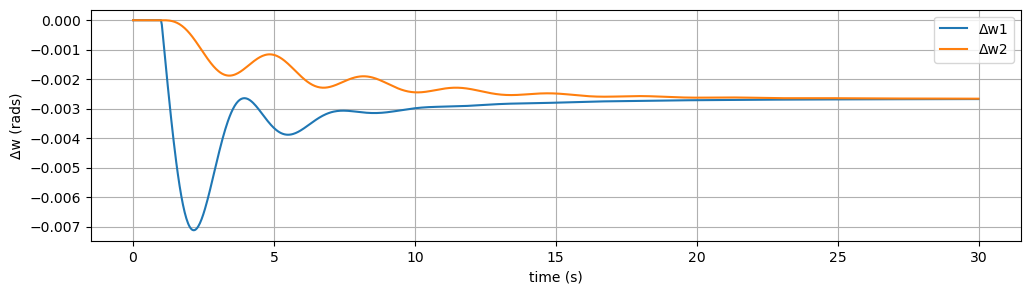

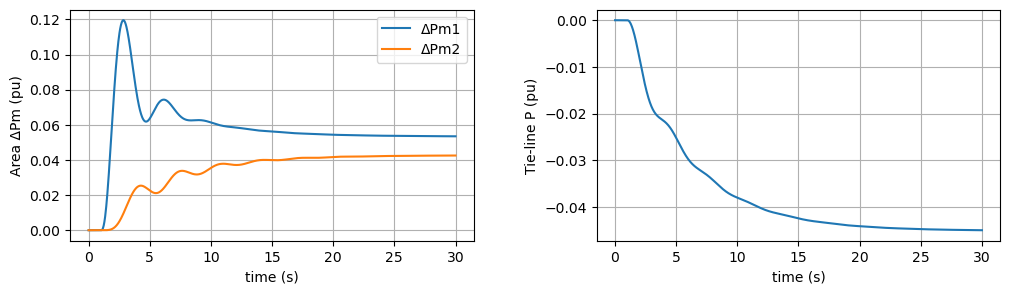

In [11]:
# System data
R = [0.05, 0.0625]
D = [0.6, 0.9]
M = [10, 6]
Tch = [0.5, 0.6]
Kg = [100, 53.3333]
Tg = [1/Kg[0]/R[0], 1/Kg[1]/R[1]]
Tl = 2

# Conteingency data
Area = 1
ΔPL_value = -0.1
T = 30

# Create input signals
t = numpy.linspace(0,T,1000)
ΔPL = get_step(t, 1, ΔPL_value)

# Model frequency response
Δw1, Δw2, mod = interconnected_frequency_primary(Area, R, D, M, Tch, Kg, Tg, Tl, t, ΔPL)

# Plot frequency response
plot_Δw(t, Δw1, Δw2)

# Model power response
Tie, P1, P2 = interconnected_power(mod, t, Δw1, Δw2)

# Plot power response
plot_Ppu(t, Tie, P1, P2)

The tools from previous notebooks can also be used to provide more details about the simulated case studies. However, we need to create an interface to pass information between the tools (i.e., `R` and `D`) and display the flow across the tie line.

In [12]:
def get_Tie_Data(Dist, Generators, Damping, Kg):
    R = [0, 0]
    for gen in Generators:
        R[gen['Area']-1] += 1/gen['R']
    for x in range(len(R)):
        R[x] = 1/R[x]
    D = [Damping[0]['D'], Damping[1]['D']]
    # Tg = [1/Kg[0]/R[0], 1/Kg[1]/R[1]]

    return R, D

The case studies can now be modelled as follows:

A disturbance occurred in Area 1
As a result generation is suddenlly lower than demand by 100.0000 MW

Disturbance: -100.0000 MW (-0.1000 pu)
G1) Area1, Capacity:    1000.00 MW, R:    0.0500 pu, Output:    500.00 MW
G2) Area2, Capacity:    1000.00 MW, R:    0.0625 pu, Output:    500.00 MW
L1) Area1, D: 0.6000 pu
L2) Area2, D: 0.9000 pu
*Assuming a 1000 MVA base

The frequency changed by -0.0027 pu (-0.1333 Hz), so the new freqency is 49.8667 Hz
           ∆Pm and D∆ω     Operation
          (pu)       (MW)       (MW)
G1)     0.0533    53.3333   553.3333 (  500.0000+   53.3333+    0.0000)
G2)     0.0427    42.6667   542.6667 (  500.0000+   42.6667+    0.0000)
L1)    -0.0016    -1.6000
L2)    -0.0024    -2.4000
All:             100.0000
The disturbace causes power to flow from Area 2 to Area 1
ΔPtie: 0.0451 pu (45.0667 MW)
As a result Area 1 is currently importing 45.0667 MW from Area 2


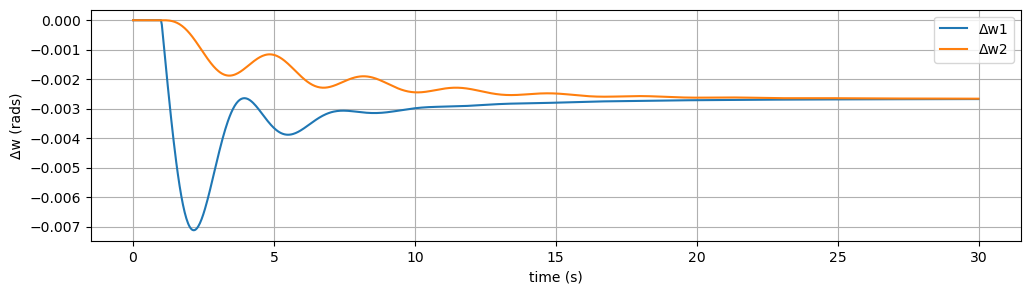

Δw: -0.0027 pu after 30 seconds
Tie: -0.0449 pu after 30 seconds


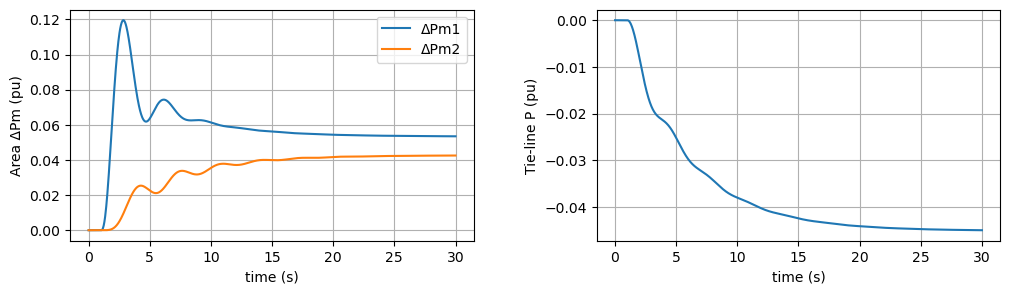

In [13]:
Dist = {
    'Area': 1,
    'Magnitude': -100,  # Positive: Generation is higher than load
    'Flow': 0  # From area 1 to 2 by default
}
Gen = [
    {'Area':1, 'Capacity': 1000, 'R':0.0500, 'Units': 'pu', 'Output': 500},
    {'Area':2, 'Capacity': 1000, 'R':0.0625, 'Units': 'pu', 'Output': 500}
]
Load = [
    {'D':0.6, 'Units': 'pu'},
    {'D':0.9, 'Units': 'pu'}
]
Base = 1000
F = 50
T = 30
get_Primary_Response(Dist, Gen, Load, Base, F)

# System data
M = [10, 6]
Tch = [0.5, 0.6]
Kg = [100, 53.3333]
Tl = 2

Disturbance, Generators, Damping = get_pu(Dist, Gen, Load, Base, F)
Δw, _, _ = get_Δw(Disturbance, Generators, Damping, F)

# Print tie line
R, D = get_Tie_Data(Dist, Generators, Damping, Kg)
Tg = [1/Kg[0]/R[0], 1/Kg[1]/R[1]]
ΔPtie, ΔPtie_pu, Ptie, a1, a2 = get_TieLine(Δw, Disturbance, Generators, Damping, Base)
print_TieLine(ΔPtie, ΔPtie_pu, Ptie, a1, a2)

# Create input signals
t = numpy.linspace(0,T,1000)
ΔPL = get_step(t, 1, Disturbance['Magnitude'])

# Model frequency response
Δw1, Δw2, mod = interconnected_frequency_primary(Dist['Area'], R, D, M, Tch, Kg, Tg, Tl, t, ΔPL)

# Plot frequency response
plot_Δw(t, Δw1, Δw2)

# Model power response
Tie, P1, P2 = interconnected_power(mod, t, Δw1, Δw2)

# Plot power response
plot_Ppu(t, Tie, P1, P2)
print('Δw: %.4f pu after %d seconds'%(Δw1[-1], T))
print('Tie: %.4f pu after %d seconds'%(Tie[-1], T))

[Back to top](#EEEN30131-Power-System-Analysis:-Week-05---Interconnected-Systems)

### Secondary response

It is time to extend the control model to include both primary and secondary frequency control.

![Week05_Interconnected_Secondary.png](Figures/Week05_Interconnected_Secondary.png)

For this purpose, the transfer function has to be updated to include the `ACE` models.

In [14]:
def interconnected_frequency_secondary(mod, Area, ΔPL_value, T):
    # Input signals
    t = numpy.linspace(0, T, 1000)
    Init = 1
    ΔPL = []
    for x in t:
        if x < Init:
            ΔPL.append(0)
        else:
            ΔPL.append(-ΔPL_value)

    # Assigning contingency to an area
    if Area == 1:
        a = 0
        b = 1
    else:
        b = 0
        a = 1
    mod['a'] = a
    mod['b'] = b

    # Developing control equations
    K1 = 1 + mod['A'][a] * mod['G'][a] * mod['P'][a] * \
        (mod['K'][a]*mod['B'][a] + mod['1/R'][a])
    K2 = -mod['A'][a] * (1 + mod['G'][a] * mod['P'][a] * mod['K'][a])
    K3 = -mod['A'][a]
    K4 = 1 + mod['A'][b] * mod['G'][b] * mod['P'][b] * \
        (mod['K'][b] * mod['B'][b] + mod['1/R'][b])
    K5 = mod['A'][b] * (1 + mod['G'][b] * mod['P'][b] * mod['K'][b])

    # Solving for Δw
    TF1 = K3/K2 * (1 + mod['T'] * K5/K4) / \
        (K1/K2 * (1 + mod['T']*K5/K4) - mod['T'])
    t, Δw1 = control.forced_response(TF1, t, ΔPL)

    TF2 = (mod['T'] * K3/K1)/(mod['T'] + K4/K5 * (1 - mod['T'] * K2/K1))
    _, Δw2 = control.forced_response(TF2, t, ΔPL)

    return t, Δw1, Δw2

We now have enough tools to model the primary and secondary response of the system.

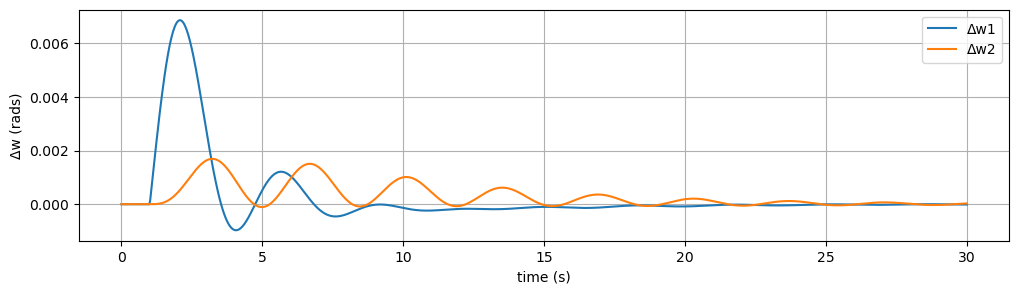

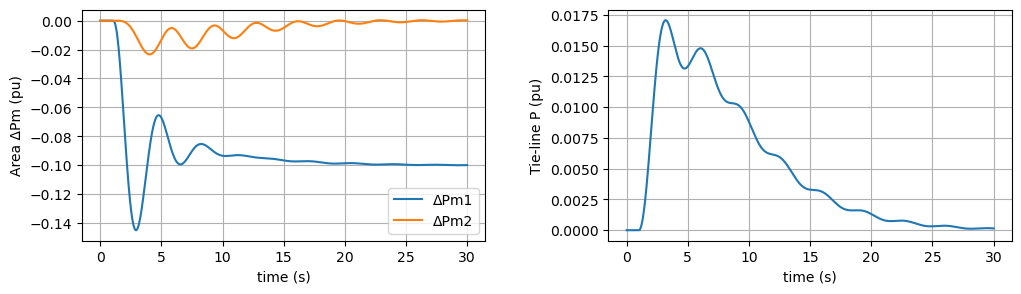

In [15]:
R = [0.05, 0.0625]
Beta = [20.6, 16.9]
D = [0.6, 0.9]
M = [10, 6]
Tch = [0.5, 0.6]
Kt = [0.3, 0.3]
Kg = [100, 53.3333]
Tg = [1/Kg[0]/R[0], 1/Kg[1]/R[1]]
Tl = 2

Area = 1
ΔPL = 0.1
T = 30
mod = interconnected_model(R, D, M, Tch, Kg, Tg, Tl, Beta, Kt)
t, Δw1, Δw2 = interconnected_frequency_secondary(mod, Area, ΔPL, T)
Tie, P1, P2 = interconnected_power(mod, t, Δw1, Δw2)
plot_Δw(t, Δw1, Δw2)
plot_Ppu(t, Tie, P1, P2)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-05---Interconnected-Systems)